In [1]:

import os
import sys
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn
import numpy as np
import pandas as pd
import pylab
import sklearn.preprocessing

import scgenome
import scgenome.db.qc
import scgenome.cnplot
import scgenome.cnfilter
import scgenome.cnclones

LOGGING_FORMAT = "%(asctime)s - %(levelname)s - %(message)s"
logging.basicConfig(format=LOGGING_FORMAT, stream=sys.stderr, level=logging.INFO)

sample_ids = [
    'SA1090',
    'SA921',
    'SA922',
]



Download zenodo data using wget:

```
mkdir zenodo_data/
wget https://zenodo.org/record/5725635/files/ov2295_cell_cn.csv.gz?download=1 -O zenodo_data/ov2295_cell_cn.csv.gz
wget https://zenodo.org/record/5725635/files/ov2295_cell_metrics.csv.gz?download=1 -O zenodo_data/ov2295_cell_metrics.csv.gz
```



# Load CN data


In [2]:

cn_data = pd.read_csv(
    'zenodo_data/ov2295_cell_cn.csv.gz',
    dtype={
        'cell_id': 'category',
        'sample_id': 'category',
        'library_id': 'category',
        'chr': 'category',
    })

metrics_data = pd.read_csv(
    'zenodo_data/ov2295_cell_metrics.csv.gz',
    dtype={
        'cell_id': 'category',
        'sample_id': 'category',
        'library_id': 'category',
    })

scgenome.utils.union_categories([cn_data, metrics_data])

hmmcopy = scgenome.pp.convert_dlp_hmmcopy(metrics_data, cn_data)


/Users/mcphera1/Projects/scgenome/venv/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)



# Poor quality cell


<AxesSubplot:xlabel='chromosome'>

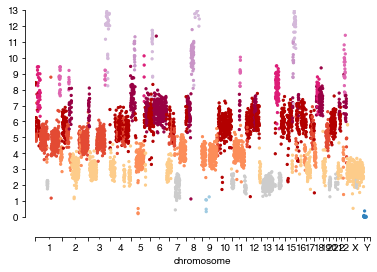

In [3]:

cell_id = hmmcopy.obs.query('total_reads > 500000 and quality < 0.75').index[0]

scgenome.pl.plot_cn_profile(
    hmmcopy, cell_id,
    value_layer_name='copy',
    state_layer_name='state')



# Low read count cell


<AxesSubplot:xlabel='chromosome'>

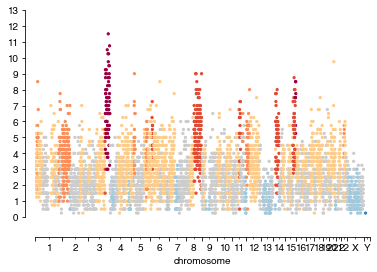

In [4]:

cell_id = hmmcopy.obs.query('total_reads < 500000').query('total_reads > 10000').index[0]

scgenome.pl.plot_cn_profile(
    hmmcopy, cell_id,
    value_layer_name='copy',
    state_layer_name='state')



# Plot PCA components


In [5]:

# import importlib
# scgenome.cnplot = importlib.reload(scgenome.cnplot)
# scgenome.cnplot.plot_pca_components(cn_data, n_components=4)



# Calculate clones using kmeans


In [6]:

hmmcopy = scgenome.pp.calculate_filter_metrics(hmmcopy)
hmmcopy = scgenome.pp.filter_cells(hmmcopy)


/Users/mcphera1/Projects/scgenome/venv/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/mcphera1/Projects/scgenome/venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/mcphera1/Projects/scgenome/scgenome/preprocessing/filtering.py:104: RuntimeWarning: Mean of empty slice
  adata.obsm['copy_state_diff_mean'] = np.nanmean(adata.obsm['copy_state_diff'], axis=1)
2022-02-07 14:55:57,262 - WARNING - No is_s_phase in AnnData.obs. Skipping filter_is_s_phase
--- Logging error ---
Traceback (most recent call last):
  File "/Users/mcphera1/miniconda3/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Users/mcphera1/miniconda3/lib/python3.7/logg

In [7]:

hmmcopy = scgenome.tl.cluster_cells_kmeans(hmmcopy, max_k=30)


/Users/mcphera1/Projects/scgenome/scgenome/preprocessing/transform.py:23: RuntimeWarning: Mean of empty slice
  bin_means = np.nanmean(data, axis=0)
2022-02-07 14:55:57,841 - INFO - trying with max k=30
2022-02-07 14:55:57,843 - INFO - trying with k=2
2022-02-07 14:55:58,937 - INFO - trying with k=3
2022-02-07 14:56:00,300 - INFO - trying with k=4
2022-02-07 14:56:02,080 - INFO - trying with k=5
2022-02-07 14:56:04,408 - INFO - trying with k=6
2022-02-07 14:56:07,264 - INFO - trying with k=7
2022-02-07 14:56:10,489 - INFO - trying with k=8
2022-02-07 14:56:14,005 - INFO - trying with k=9
2022-02-07 14:56:17,795 - INFO - trying with k=10
2022-02-07 14:56:21,772 - INFO - trying with k=11
2022-02-07 14:56:26,127 - INFO - trying with k=12
2022-02-07 14:56:31,355 - INFO - trying with k=13
2022-02-07 14:56:37,459 - INFO - trying with k=14
2022-02-07 14:56:44,074 - INFO - trying with k=15
2022-02-07 14:56:51,788 - INFO - trying with k=16
2022-02-07 14:57:00,195 - INFO - trying with k=17
2022-

/Users/mcphera1/Projects/scgenome/scgenome/preprocessing/transform.py:23: RuntimeWarning: Mean of empty slice
  bin_means = np.nanmean(data, axis=0)
/Users/mcphera1/Projects/scgenome/scgenome/tools/sorting.py:34: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')


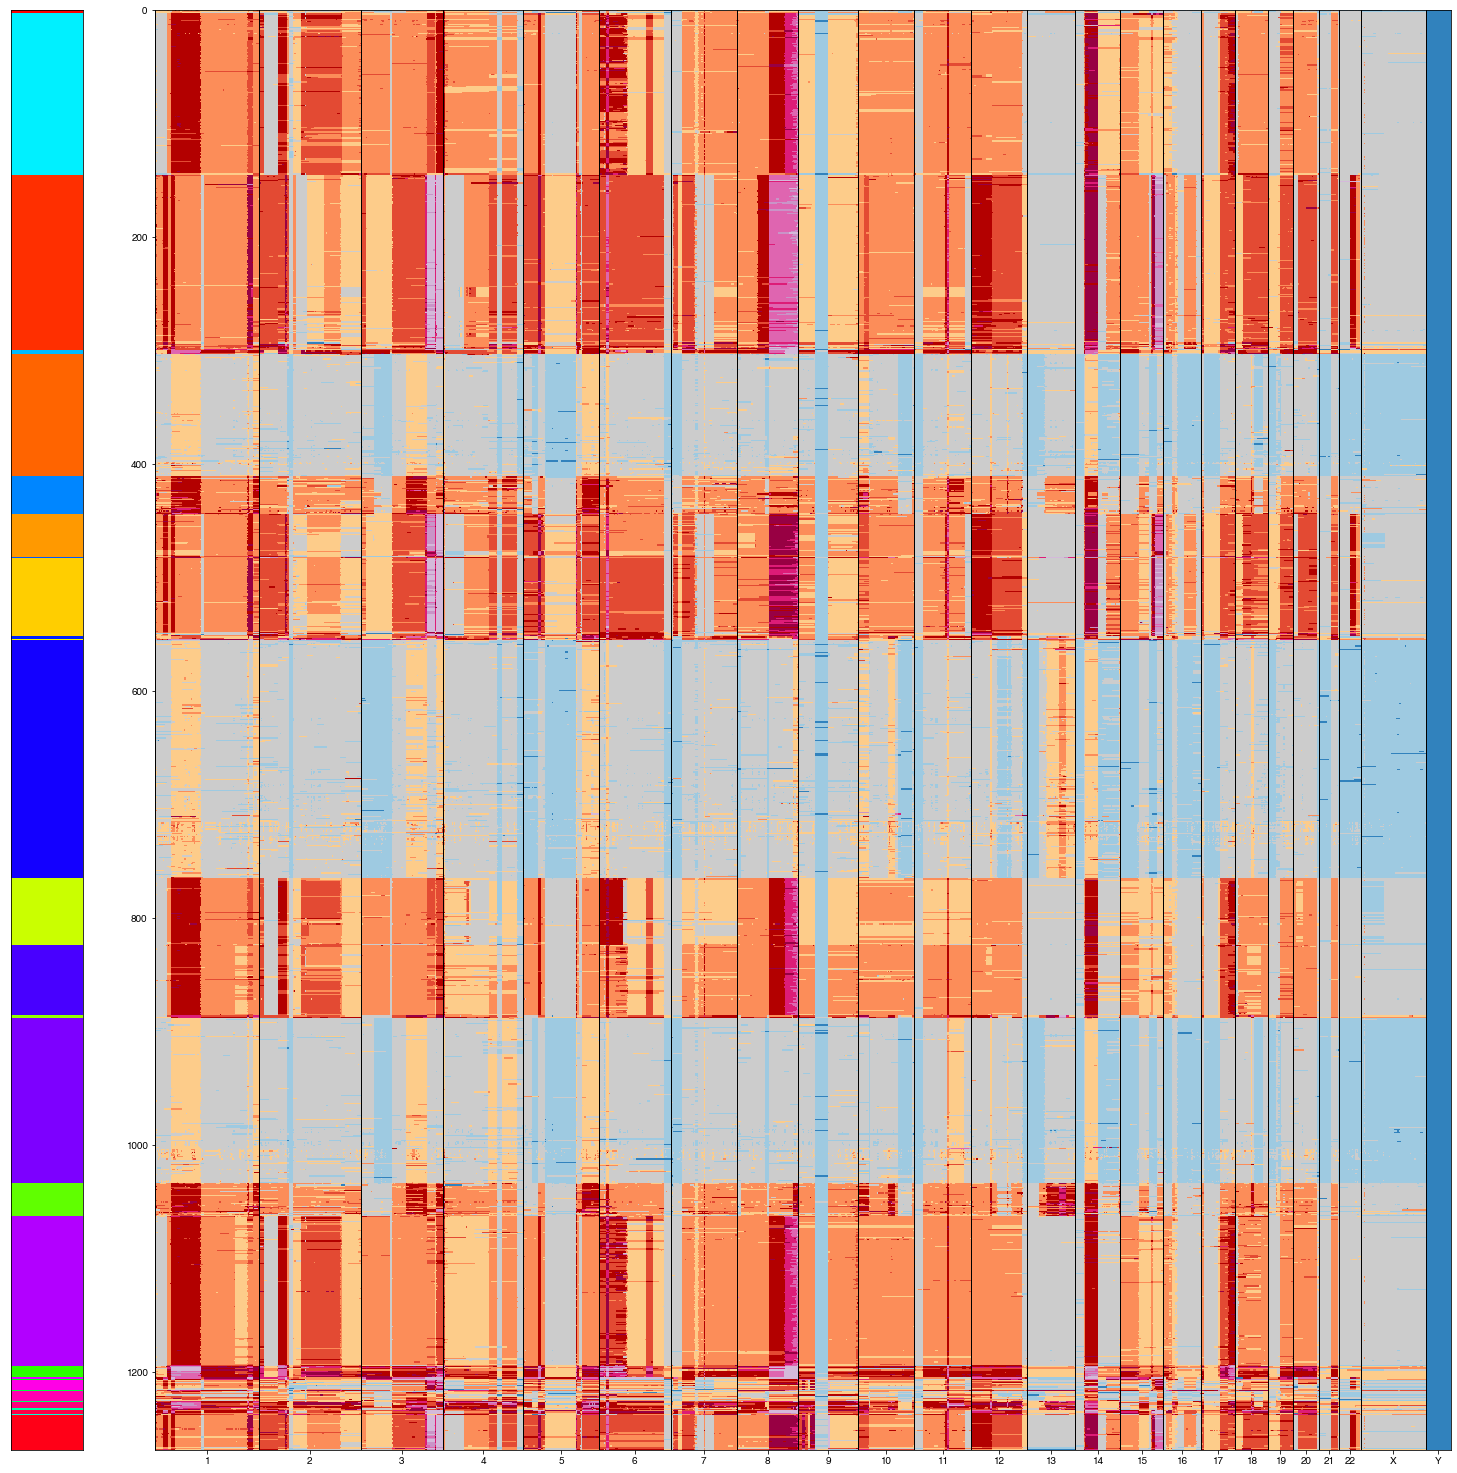

In [8]:

hmmcopy = scgenome.tl.sort_cells(hmmcopy, layer_name='copy')

fig = plt.figure(figsize=(20, 20))
fig = scgenome.pl.plot_cell_cn_matrix_clusters_fig(hmmcopy, fig=fig)


In [9]:

gtf_filename = './Homo_sapiens.GRCh37.73.gtf.gz'

genes = scgenome.tl.read_ensemble_genes_gtf(gtf_filename)

hmmcopy_genes = scgenome.tl.aggregate_genes(hmmcopy, genes)


In [12]:

hr_genes = [
    'BLM',
    'BRCA1',
    'BRCA2',
    'EME1',
    'MRE11A', #'MRE11',
    'MUS81',
    'NBN',
    'POLD1',
    'POLD2',
    'POLD3',
    'POLD4',
    'RAD50',
    'RAD51',
    'RAD51B',
    'RAD51C',
    'RAD51D',
    'RAD52',
    'RAD54B',
    'RAD54L',
    'RPA1',
    'RPA2',
    'RPA3',
    'RPA4',
    'C7orf76', #'SEM1',
    'SSBP1',
    'TOP3A',
    'TOP3B',
    'XRCC2',
    'XRCC3',
]

hr_gene_info = genes.as_df().query('gene_name.isin(@hr_genes)', engine='python')
hr_gene_info = hr_gene_info[hr_gene_info['Chromosome'].isin(hmmcopy.var['chr'].unique())]

hr_gene_cn = hmmcopy_genes.to_df(layer='copy').loc[:, hr_gene_info['gene_id'].values].stack().rename('copy').reset_index()
hr_gene_cn = hr_gene_cn.merge(genes.as_df()[['gene_id', 'gene_name']])


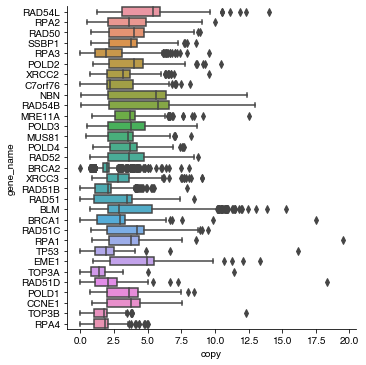

In [13]:

import seaborn as sns

sns.catplot(y='gene_name', x='copy', data=hr_gene_cn, kind='box')


In [46]:

hmmcopy_genes_clusters = scgenome.tl.aggregate_clusters_hmmcopy(hmmcopy_genes)

cluster_sizes = hmmcopy.obs['cluster_id'].value_counts()
filtered_clusters = list(str(a) for a in cluster_sizes[cluster_sizes > 50].index)


<AxesSubplot:xlabel='gene_name', ylabel='cluster_id'>

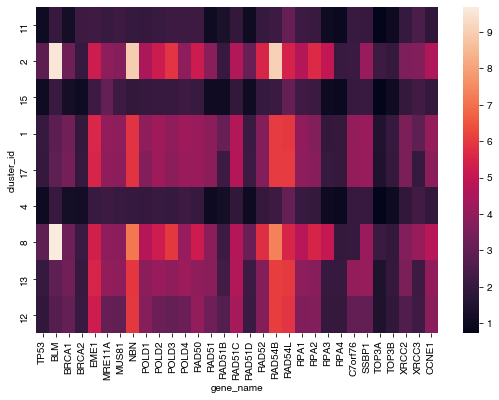

In [47]:

hr_gene_cn = (
    hmmcopy_genes_clusters
        .to_df(layer='copy').T
        .set_index(pd.Index(hmmcopy_genes_clusters.var['gene_name'].values, name='gene_name'), append=False).T
        .loc[filtered_clusters, hr_genes])

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(hr_gene_cn)


In [10]:

# clusters = scgenome.cncluster.umap_hdbscan_cluster(cn)
# clusters


cell_id  cluster_id      umap1     umap2
0      SA922-A90554B-R32-C23          12  16.130816  9.205617
1     SA1090-A96213A-R34-C20           0   6.521286  9.407173
2     SA1090-A96213A-R34-C40          15  14.871066  6.903368
3     SA1090-A96213A-R26-C54           0   5.784012  9.645854
4      SA921-A90554A-R08-C30           1   0.975852  4.247262
...                      ...         ...        ...       ...
1961   SA922-A90554B-R30-C16           6   4.556883 -1.873774
1962  SA1090-A96213A-R20-C41           0   5.781394  8.061240
1963   SA921-A90554A-R15-C12           2  -4.255668  6.568119
1964   SA922-A90554B-R26-C39          -1  14.613179  7.121934
1965   SA921-A90554A-R14-C39          16  14.992161  7.178802

[1966 rows x 4 columns]

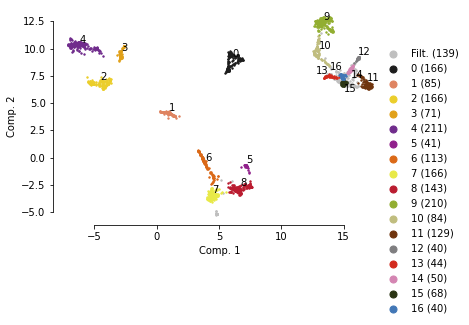

In [11]:

# scgenome.cncluster.plot_umap_clusters(plt.gca(), clusters)



Plot the raw normalized copy number as a heatmap with rows as cells, x axis as the chromosomes.  A color bar on the left shows cluster assignments.  Rows are ordered within each cluster.


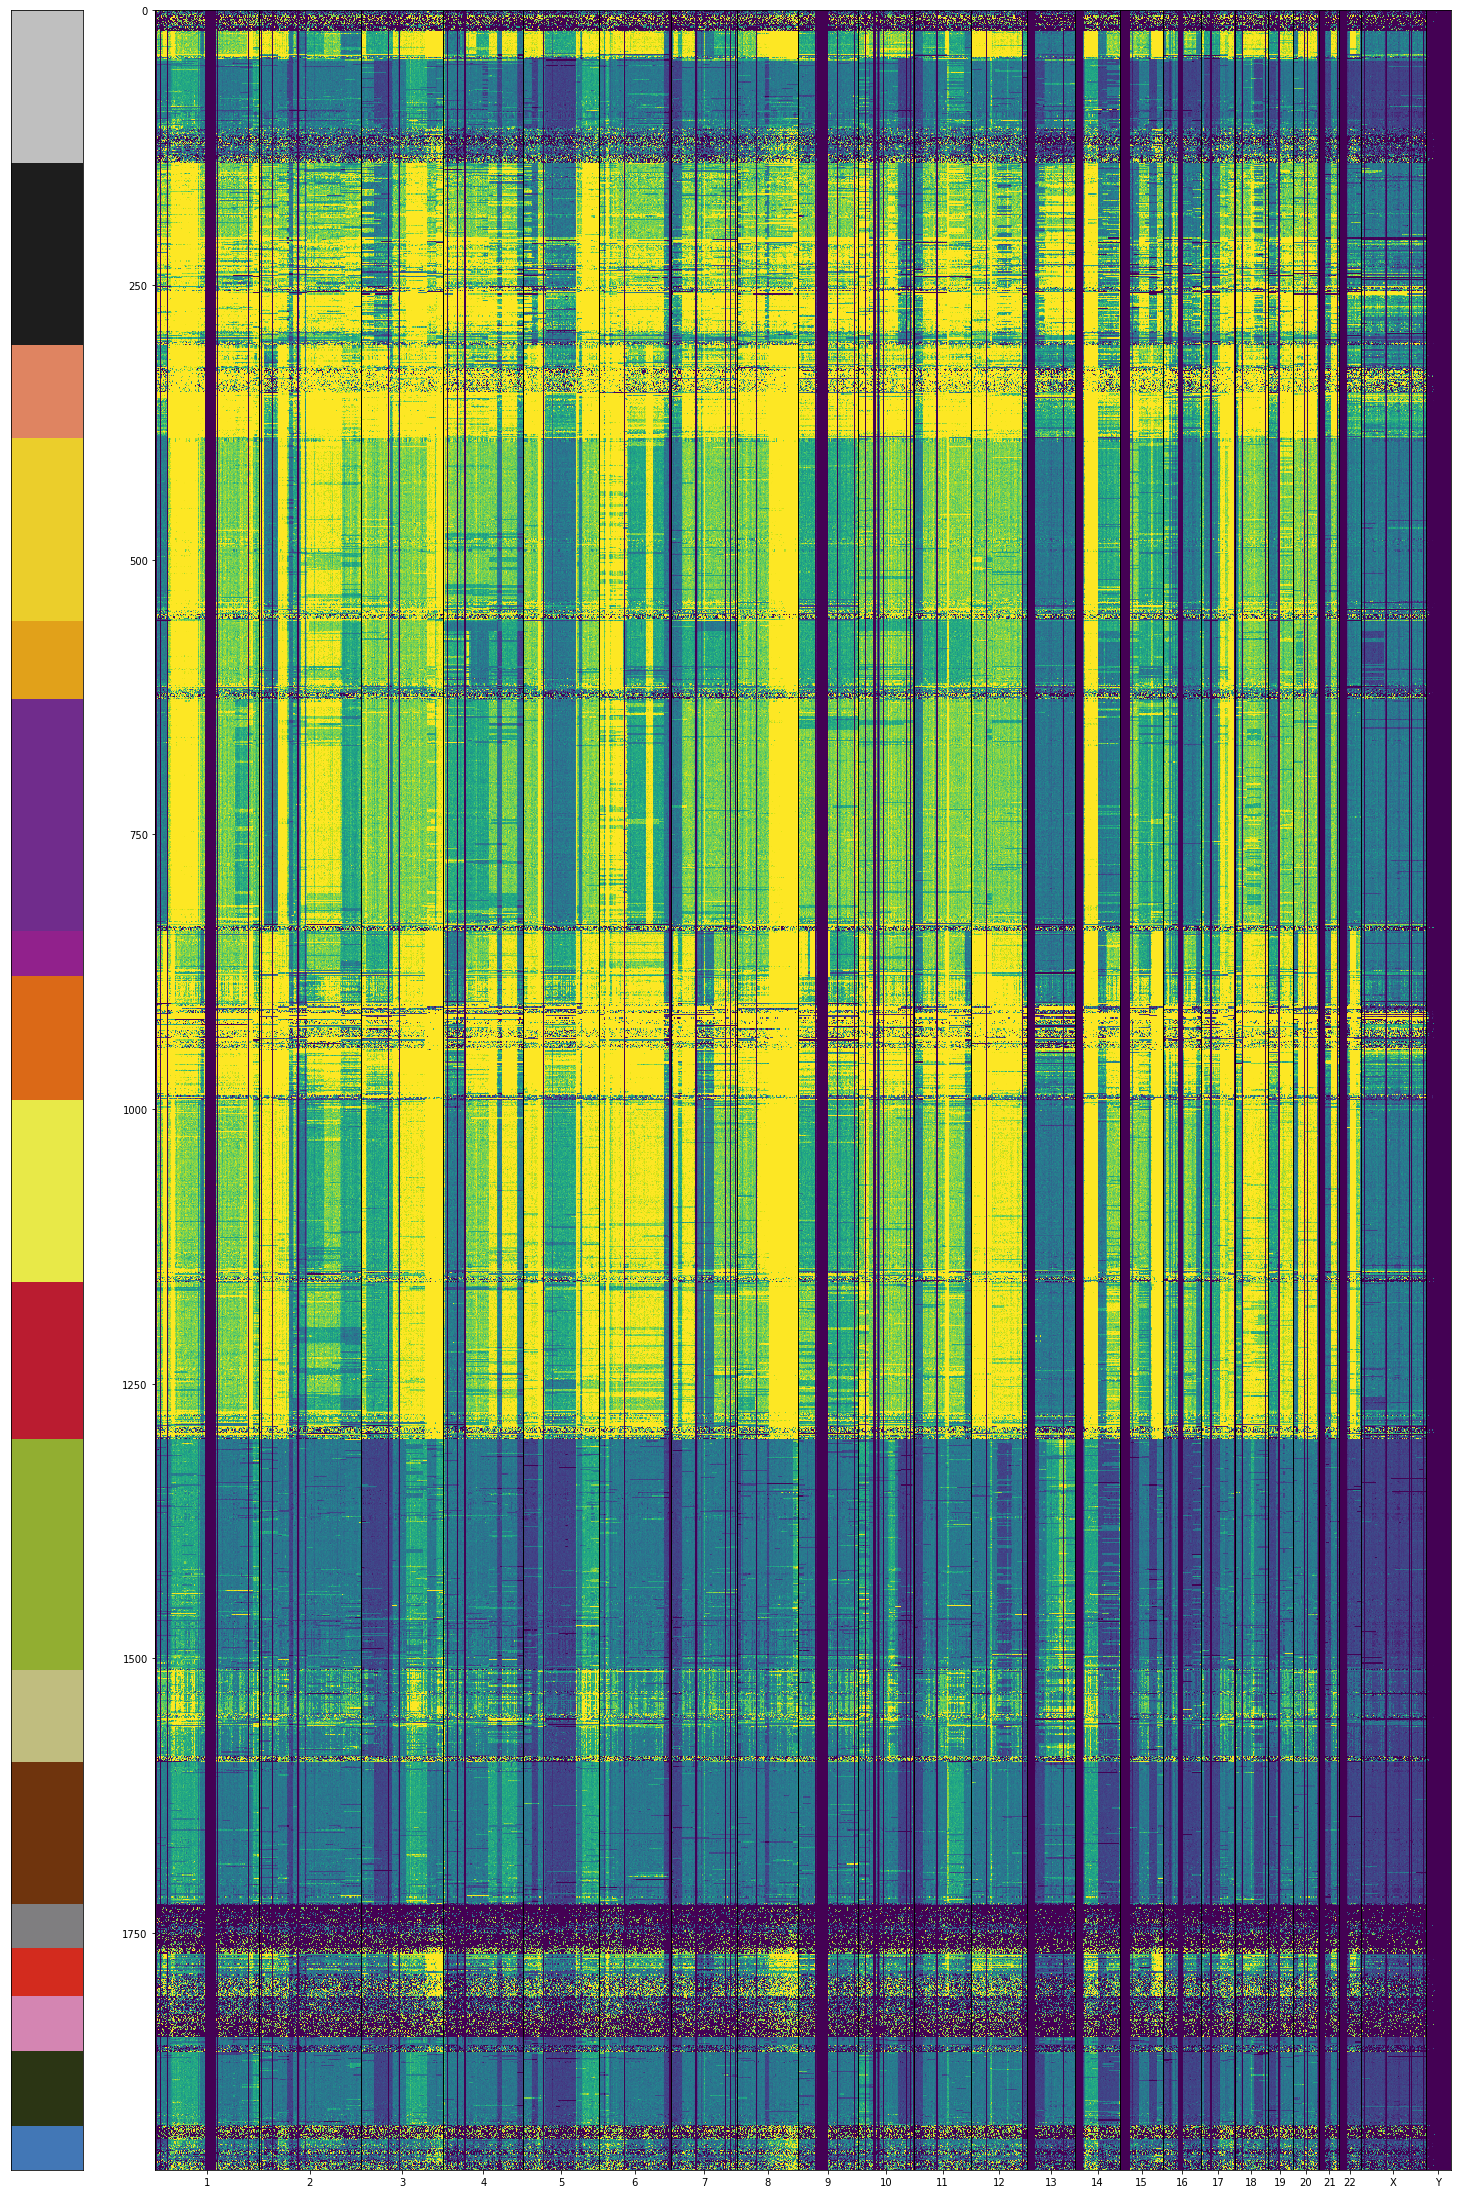

In [15]:

# fig = plt.figure(figsize=(20, 30))

# matrix_data = scgenome.cnplot.plot_clustered_cell_cn_matrix_figure(
#     fig, plot_data, 'copy', cluster_field_name='cluster_id', raw=True)
